In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split ,RandomizedSearchCV , GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# Load the dataset
train_data = pd.read_csv('train.csv') 
test_data = pd.read_csv('test.csv') 


# Set Flag
train_data["train_flag"] = 1
test_data["train_flag"] = 0
test_data["y"] = -99 # temporary

# merge
total_data = pd.concat([train_data, test_data], axis = 0)

In [3]:
print(total_data.columns)

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'train_flag'],
      dtype='object')


In [4]:
total_data.head(2)

,id,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,train_flag
0,1,30,unemployed,married,primary,no,1787,no,no,cellular,oct,79,1,-1,0,unknown,no,1
1,2,33,services,married,secondary,no,4789,yes,yes,cellular,may,220,1,339,4,failure,no,1


In [5]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4521 entries, 0 to 521
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4521 non-null   int64 
 1   age         4521 non-null   int64 
 2   job         4521 non-null   object
 3   marital     4521 non-null   object
 4   education   4521 non-null   object
 5   default     4521 non-null   object
 6   balance     4521 non-null   int64 
 7   housing     4521 non-null   object
 8   loan        4521 non-null   object
 9   contact     4521 non-null   object
 10  month       4521 non-null   object
 11  duration    4521 non-null   int64 
 12  campaign    4521 non-null   int64 
 13  pdays       4521 non-null   int64 
 14  previous    4521 non-null   int64 
 15  poutcome    4521 non-null   object
 16  y           4521 non-null   object
 17  train_flag  4521 non-null   int64 
dtypes: int64(8), object(10)
memory usage: 671.1+ KB


In [6]:
total_data['y'] = total_data['y'].map({'yes': 1, 'no': 0,-99:-99})

In [7]:
total_data['y'].unique()

array([  0,   1, -99])

In [8]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4521 entries, 0 to 521
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4521 non-null   int64 
 1   age         4521 non-null   int64 
 2   job         4521 non-null   object
 3   marital     4521 non-null   object
 4   education   4521 non-null   object
 5   default     4521 non-null   object
 6   balance     4521 non-null   int64 
 7   housing     4521 non-null   object
 8   loan        4521 non-null   object
 9   contact     4521 non-null   object
 10  month       4521 non-null   object
 11  duration    4521 non-null   int64 
 12  campaign    4521 non-null   int64 
 13  pdays       4521 non-null   int64 
 14  previous    4521 non-null   int64 
 15  poutcome    4521 non-null   object
 16  y           4521 non-null   int64 
 17  train_flag  4521 non-null   int64 
dtypes: int64(9), object(9)
memory usage: 671.1+ KB


In [9]:
cat_features=[i for i in total_data.columns if total_data.dtypes[i]=='object']

In [10]:
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [11]:
# Convert categorical variables to numerical

label_encoder = LabelEncoder()
for col in cat_features:
    total_data[col] = label_encoder.fit_transform(total_data[col])


In [12]:
total_data.job.unique()

array([10,  7,  4,  1,  6,  9,  2,  0,  8,  3,  5, 11])

In [13]:
total_data.head(3)

,id,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y,train_flag
0,1,30,10,1,0,0,1787,0,0,0,10,79,1,-1,0,3,0,1
1,2,33,7,1,1,0,4789,1,1,0,8,220,1,339,4,0,0,1
2,3,35,4,2,2,0,1350,1,0,0,0,185,1,330,1,0,0,1


In [14]:
features = set(total_data.columns)
# remove unness features and target
rm = ['id','y','duration','pdays','train_flag']
for r in rm:
    features.remove(r)
features = list(features)
print(features)

['poutcome', 'loan', 'age', 'balance', 'campaign', 'housing', 'marital', 'previous', 'contact', 'month', 'education', 'job', 'default']


In [15]:
features

['poutcome',
 'loan',
 'age',
 'balance',
 'campaign',
 'housing',
 'marital',
 'previous',
 'contact',
 'month',
 'education',
 'job',
 'default']

In [20]:
# Split the dataset into training and testing sets
train_data = total_data[total_data["train_flag"] == 1]
test_data = total_data[total_data["train_flag"] == 0]
X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data['y'], test_size=0.2, random_state=42)


# Imbalance data

In [21]:
y_train.value_counts()

0    2823
1     376
Name: y, dtype: int64

In [22]:
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [23]:
y_train.value_counts()

0    2823
1    2823
Name: y, dtype: int64

In [24]:

# Build the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [25]:

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')



Accuracy: 0.90


AUC-ROC: 0.65


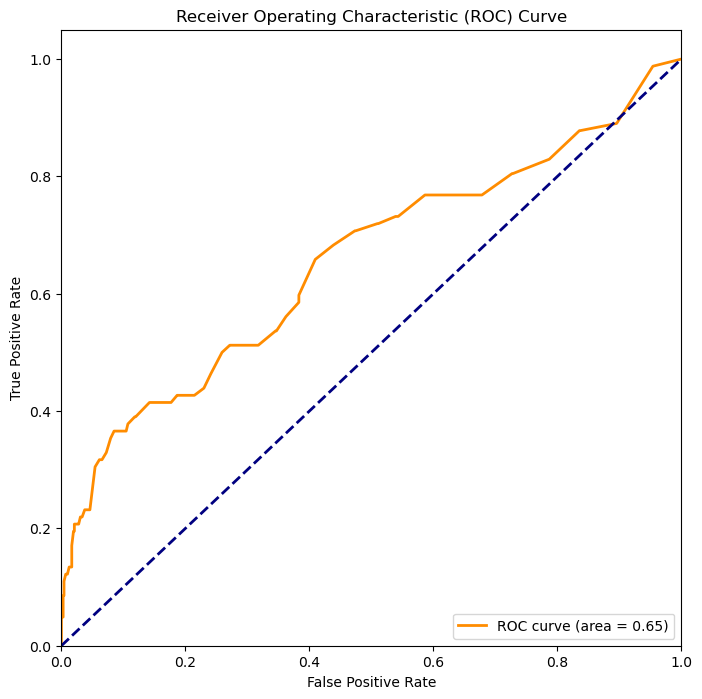


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       718
           1       0.53      0.21      0.30        82

    accuracy                           0.90       800
   macro avg       0.72      0.59      0.62       800
weighted avg       0.88      0.90      0.88       800



In [26]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

# Calculate AUC
roc_auc = auc(fpr, tpr)
print(f'AUC-ROC: {roc_auc:.2f}')

# Display ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Display classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred))

In [27]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [28]:

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

rf_grid = GridSearchCV(estimator=rf, param_grid=random_grid, cv=5, verbose=2, n_jobs=-1)

In [ ]:
# Fit the model to the data
rf_grid.fit(X_train, y_train)
rf_random.fit(X_train, y_train)

In [30]:
# print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')
best_param_1 = rf_grid.best_params_
best_param_2 = rf_random.best_params_

Best Parameters:  {'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': False}  



In [31]:
print(best_param_1)
print(best_param_2)

{'bootstrap': False, 'max_depth': 80, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
{'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': False}


In [32]:
gridmf = RandomForestClassifier(**best_param_1) 
randmf = RandomForestClassifier(**best_param_2) 

gridmf.fit( X_train, y_train) 
randmf.fit( X_train, y_train) 

/Users/punnakunphongsai/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/punnakunphongsai/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(bootstrap=False, max_depth=110, max_features='auto',
                       min_samples_split=6, n_estimators=50)

In [39]:
y_pred = randmf.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.90


AUC-ROC: 0.65


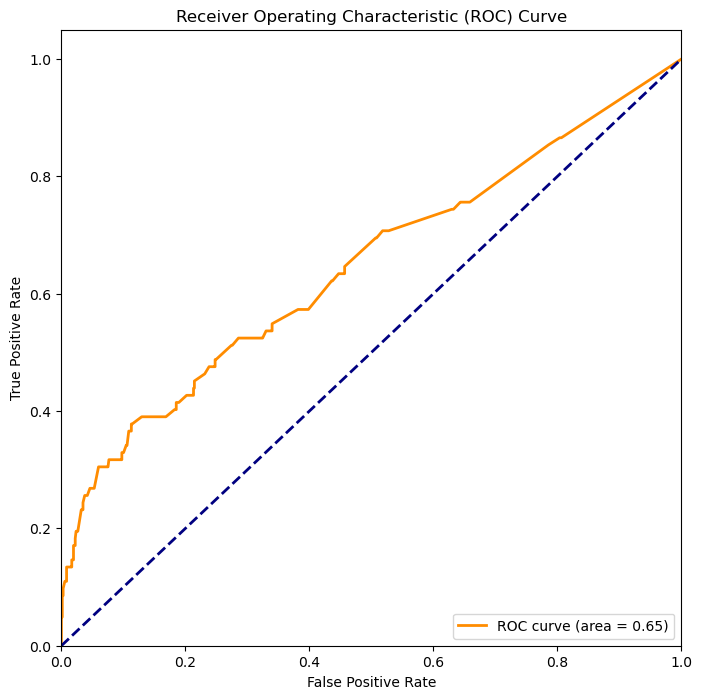


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       718
           1       0.65      0.13      0.22        82

    accuracy                           0.90       800
   macro avg       0.78      0.56      0.59       800
weighted avg       0.88      0.90      0.87       800



In [40]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, randmf.predict_proba(X_test)[:, 1])

# Calculate AUC
roc_auc = auc(fpr, tpr)
print(f'AUC-ROC: {roc_auc:.2f}')

# Display ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Display classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred))

In [41]:
y_pred = gridmf.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.90


AUC-ROC: 0.66


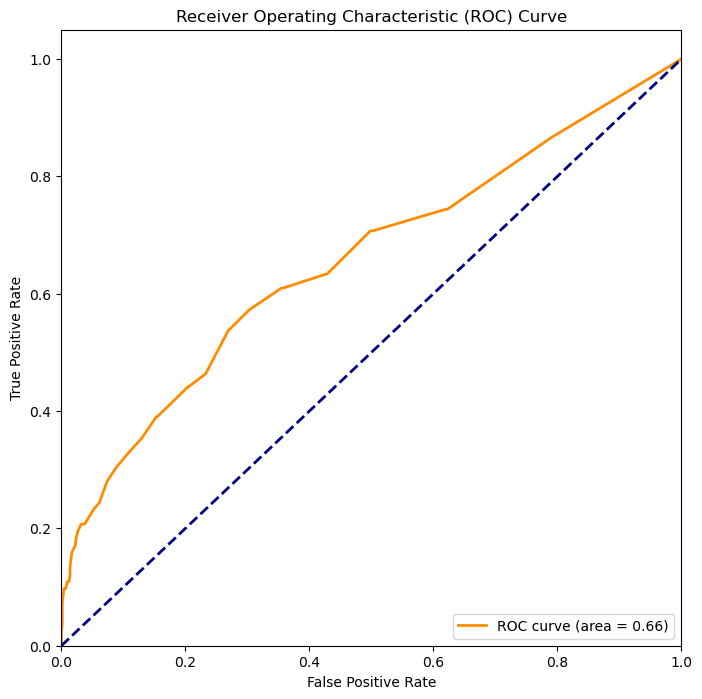


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       718
           1       0.52      0.13      0.21        82

    accuracy                           0.90       800
   macro avg       0.72      0.56      0.58       800
weighted avg       0.87      0.90      0.87       800



In [42]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, gridmf.predict_proba(X_test)[:, 1])

# Calculate AUC
roc_auc = auc(fpr, tpr)
print(f'AUC-ROC: {roc_auc:.2f}')

# Display ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Display classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred))

In [43]:
test_x = test_data[features]

y_test_pred = gridmf.predict_proba(test_x)[:, 1]


In [45]:
answer = pd.DataFrame({'id': test_data['id'], 'y': y_test_pred})

# Save the DataFrame to a CSV file
answer.to_csv('231124_Fallin.csv', index=False)

In [46]:
print(answer.head())

     id     y
0  4000  0.02
1  4001  0.08
2  4002  0.04
3  4003  0.14
4  4004  0.04
